In [1]:
#basic
import numpy as np
import pandas as pd
import time
import pickle
import csv

#ploting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



#### Import original data and splited data index ####

In [2]:
housing_modified = pd.read_csv("../data/housing_modified.csv")     # housing_modified is DataFrame
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns  

with open('bosten_data_split.pickle', 'rb') as f:
    indexs = pickle.load(f)
y_train_index, y_val_index, y_test_index = indexs

x_train= housing_modified.iloc[y_train_index][x_column_names]
x_val= housing_modified.iloc[y_val_index][x_column_names]
x_test= housing_modified.iloc[y_test_index][x_column_names]

y_train= housing_modified.iloc[y_train_index][y_column_names]
y_val= housing_modified.iloc[y_val_index][y_column_names]
y_test= housing_modified.iloc[y_test_index][y_column_names]

In [3]:
# calculate the standardation x_train
scaler_x = StandardScaler()
scaler_x.fit(x_train)

# give the standardization to all data
x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# same for y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

########################################################
#save the mean and STD of y_test= y_test_std*y_test_STD+ y_test_mean
y_test_mean= y_test.mean()
y_test_STD= y_test.std()
print('mean and STD:', y_test_mean, y_test_STD)     
with open("y_test_mean_y_test_STD.pickle", "wb") as f:
    pickle.dump([y_test_mean, y_test_STD], f)

print(x_train_std.shape, y_train_std.shape)
x_train_inv = scaler_x.inverse_transform(x_train_std)
y_train_inv = scaler_y.inverse_transform(y_train_std)
print(x_train_inv.shape, y_train_inv.shape)

mean and STD: PRICE    21.772549
dtype: float64 PRICE    8.270778
dtype: float64
(353, 12) (353, 1)
(353, 12) (353, 1)


In [4]:
# calculate the standardation x_train
scaler_x = StandardScaler()
scaler_x.fit(x_train)

# give the standardization to all data
x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# same for y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

########################################################
#save the mean and STD of y_test= y_test_std*y_test_STD+ y_test_mean
y_test_mean= y_test.mean()
y_test_STD= y_test.std()
#print('mean and STD:', y_test_mean, y_test_STD)     
with open("y_test_mean_y_test_STD.pickle", "wb") as f:
    pickle.dump([y_test_mean, y_test_STD], f)

### Build dataset, dataloader and a FullConnect Network ###

In [5]:
train_data= TensorDataset(torch.from_numpy(x_train_std.to_numpy().astype(np.float32)), torch.from_numpy(y_train_std.to_numpy().astype(np.float32)))
validation_data= TensorDataset(torch.from_numpy(x_val_std.to_numpy().astype(np.float32)), torch.from_numpy(y_val_std.to_numpy().astype(np.float32)))
test_data= TensorDataset(torch.from_numpy(x_test_std.to_numpy().astype(np.float32)), torch.from_numpy(y_test_std.to_numpy().astype(np.float32)))

train_loader= DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)

In [ ]:
dopout_rate= 0.1   #0.3

In [15]:
class FullyConnectedNuralNetwork(nn.Module):
    
    def __init__(self):
        super(FullyConnectedNuralNetwork,self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=12,out_features= 100,bias=True),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                #nn.Dropout(p=0.3), #add dropout
                nn.Linear(in_features=100,out_features=50,bias=True),
                nn.ReLU())
        
        self.predict=nn.Sequential(
                nn.Dropout(p= dopout_rate),
                nn.Linear(in_features= 50,out_features=1,bias=True)
                #nn.ReLU()
                )
                
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.predict(x)
        return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testnet = FullyConnectedNuralNetwork().to(device)
optimizer = Adam(testnet.parameters(), lr = 0.0001)     # optimizer can be Adam or SGD
loss_func = nn.MSELoss()                                          
epoch= 500                                                        

Epoch 1, Train Loss: 1.0380, Validation Loss: 0.8199
Epoch 2, Train Loss: 0.9862, Validation Loss: 0.7938
Epoch 3, Train Loss: 0.9319, Validation Loss: 0.7682
Epoch 4, Train Loss: 0.9238, Validation Loss: 0.7444
Epoch 5, Train Loss: 0.9145, Validation Loss: 0.7216
Epoch 6, Train Loss: 0.9093, Validation Loss: 0.7003
Epoch 7, Train Loss: 0.8246, Validation Loss: 0.6797
Epoch 8, Train Loss: 0.8551, Validation Loss: 0.6603
Epoch 9, Train Loss: 0.8167, Validation Loss: 0.6417
Epoch 10, Train Loss: 0.7863, Validation Loss: 0.6240
Epoch 11, Train Loss: 0.7577, Validation Loss: 0.6072
Epoch 12, Train Loss: 0.7150, Validation Loss: 0.5906
Epoch 13, Train Loss: 0.7075, Validation Loss: 0.5751
Epoch 14, Train Loss: 0.7065, Validation Loss: 0.5603
Epoch 15, Train Loss: 0.6997, Validation Loss: 0.5464
Epoch 16, Train Loss: 0.6636, Validation Loss: 0.5326
Epoch 17, Train Loss: 0.6451, Validation Loss: 0.5194
Epoch 18, Train Loss: 0.6273, Validation Loss: 0.5066
Epoch 19, Train Loss: 0.5930, Validat

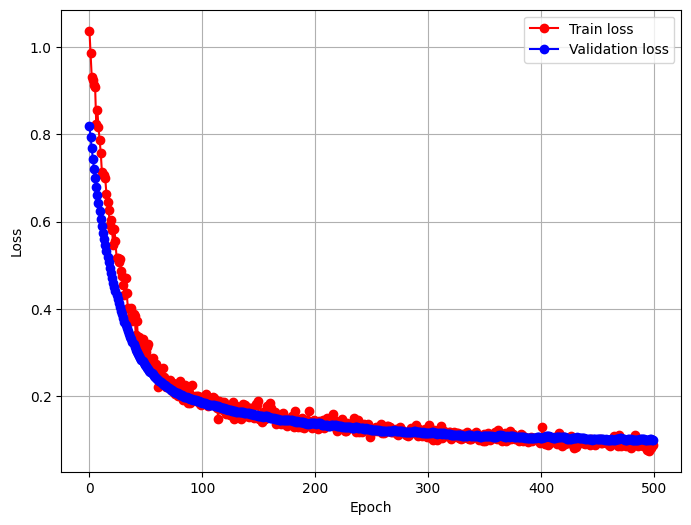

data succesfully written into train_val_loss_dp0.3.csv


In [17]:
##### Training Loop #####
train_loss_all = []
val_loss_all = []

# tain model in lopp for epoch times
for i in range(epoch):
    testnet.train()
    train_loss = 0

    for step, (b_x, b_y) in enumerate(train_loader):

        b_x, b_y = b_x.to(device), b_y.to(device)
        output = testnet(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_all.append(train_loss / len(train_loader))
    
    # Calculate validation loss
    testnet.eval()
    val_loss = 0
    with torch.no_grad():
        for b_x, b_y in validation_data:
            
            b_x, b_y = b_x.to(device), b_y.to(device)
            output = testnet(b_x)
            loss = loss_func(output, b_y)
            val_loss += loss.item()
    
    val_loss_all.append(val_loss / len(validation_data))
    
    print(f"Epoch {i + 1}, Train Loss: {train_loss_all[-1]:.4f}, Validation Loss: {val_loss_all[-1]:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(train_loss_all, 'ro-', label='Train loss')
plt.plot(val_loss_all, 'bo-', label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig(f'training_houseprice_dp{dopout_rate}.png')

# print(train_loss_all)
# print(val_loss_all)
filename= f'train_val_loss_dp{dopout_rate}.csv'
with open(filename, 'w', newline='') as csvfile:

    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['train loss', 'val loss'])

    for train_loss, val_loss in zip(train_loss_all, val_loss_all):
        csv_writer.writerow([train_loss, val_loss])

print(f"data succesfully written into {filename}")

### Save and import trained- saved model ###

In [18]:
# torch.save(testnet.state_dict(), f'./model_state_noReLU_Stdall_dp{dopout_rate}.pth')

need to add true accuracy of test data

In [13]:
test_loader= DataLoader(dataset= test_data,batch_size= 64,shuffle= True, num_workers= 2)
testnet.load_state_dict(torch.load('./model_state_noReLU_Stdall_dp0.1.pth'))
testnet.eval()
test_loss_all = []
test_loss = 0

with torch.no_grad():
    for b_x, b_y in test_data:
        
        b_x, b_y = b_x.to(device), b_y.to(device)
        output = testnet(b_x)
        loss = loss_func(output, b_y)
        test_loss += loss.item()

test_loss_all.append(test_loss / len(test_data))
print(f"Test Loss: {test_loss_all[-1]:.4f}")

Test Loss: 0.0990


C:\Users\45040\AppData\Local\Temp\ipykernel_22876\35292280.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testnet.load_state_dict(torch.load('./model_state_noReLU_Stdal

In [19]:
test_loader= DataLoader(dataset= test_data,batch_size= 64,shuffle= True, num_workers= 2)
testnet.load_state_dict(torch.load('./model_state_noReLU_Stdall_dp0.3.pth'))
testnet.eval()
test_loss_all = []
test_loss = 0

with torch.no_grad():
    for b_x, b_y in test_data:
        
        b_x, b_y = b_x.to(device), b_y.to(device)
        output = testnet(b_x)
        loss = loss_func(output, b_y)
        test_loss += loss.item()

test_loss_all.append(test_loss / len(test_data))
print(f"Test Loss: {test_loss_all[-1]:.4f}")

Test Loss: 0.1177


C:\Users\45040\AppData\Local\Temp\ipykernel_22876\2388770592.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testnet.load_state_dict(torch.load('./model_state_noReLU_Std